In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import FFNet
from cosmosis.learning import Learn, Selector
from cosmosis.dataset import SKDS

from dataset import QM7, QM7b, QM7X, QM9, ANI1x

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
from torch.optim.lr_scheduler import ReduceLROnPlateau

SKDS created...
epoch: 0 of 10, train loss: 24133.2615198206, val loss: 3597.987890625, lr: 0.01
epoch: 1 of 10, train loss: 2433.286905924479, val loss: 2438.53017578125, lr: 0.01
epoch: 2 of 10, train loss: 2223.6352041739005, val loss: 1748.1074462890624, lr: 0.01
epoch: 3 of 10, train loss: 1967.7271321614583, val loss: 1768.8135498046875, lr: 0.01
epoch: 4 of 10, train loss: 2044.7642279730903, val loss: 1380.5963989257812, lr: 0.01
epoch: 5 of 10, train loss: 1805.088595920139, val loss: 1592.340869140625, lr: 0.01
epoch: 6 of 10, train loss: 1870.0041255244503, val loss: 1424.72216796875, lr: 0.005
epoch: 7 of 10, train loss: 1482.0357711226852, val loss: 1293.935400390625, lr: 0.005
epoch: 8 of 10, train loss: 1461.144070095486, val loss: 1567.8467895507813, lr: 0.005
epoch: 9 of 10, train loss: 1406.1506370261864, val loss: 1391.895458984375, lr: 0.0025
test loss: 1632.0570475260417
y_pred:
tensor([[-271.8131],
        [-378.1300],
        [ 119.2050],
        [ 158.1913],
   

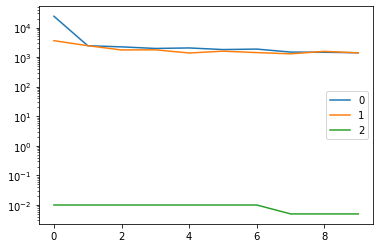

learning time: 0:00:08.660183


In [2]:
model_params = {'D_in': 128, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'ds_params': {'embed': [],
                           'make': 'make_regression',
                           'transform': None,
                           'target_transform': None,
                           'sk_params': {'n_samples': 10000,
                                         'n_features': 128}}}

opt_params = {'lr': 0.01}
crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}
sched_params = {'factor': .5,
                'patience': 1}

l = Learn([SKDS], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=10)

epoch: 0 of 100, train loss: 1492.8625881559888, val loss: 1241.4362654872239, lr: 0.01
epoch: 10 of 100, train loss: 88.42764420641794, val loss: 84.1200310587883, lr: 0.01
epoch: 20 of 100, train loss: 97.04899877972073, val loss: 117.58637166023254, lr: 0.01
epoch: 30 of 100, train loss: 99.18362651268642, val loss: 75.91251945495605, lr: 0.01
epoch: 40 of 100, train loss: 70.22486814525392, val loss: 79.52438819408417, lr: 0.005
epoch: 50 of 100, train loss: 71.98637074232101, val loss: 66.91207653284073, lr: 0.005
epoch: 60 of 100, train loss: 67.30322753720813, val loss: 58.37045627832413, lr: 0.0025
epoch: 70 of 100, train loss: 59.98002996047338, val loss: 56.166075706481934, lr: 0.00125
epoch: 80 of 100, train loss: 63.19111321369807, val loss: 54.402707397937775, lr: 0.00125
epoch: 90 of 100, train loss: 60.27095016505983, val loss: 58.670918405056, lr: 0.000625
test loss: 40.34659977753957
y_pred:
tensor([[-1517.5533],
        [-1341.8313],
        [-1837.6841],
        [-15

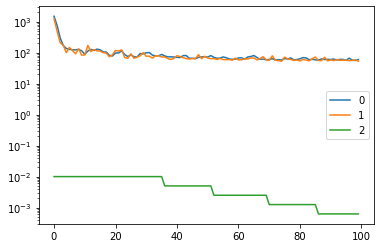

learning time: 0:01:22.933337


In [3]:
model_params = {'D_in': 23*23+23*23+23*32, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'ds_params': {'features': ['distance','coulomb'],
                           'targets': ['ae'],
                           'embed': [('atoms',7,32,0,True)],
                           'in_file': './data/qm7/qm7.mat'}}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 10,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=512, epochs=100)

epoch: 0 of 160, train loss: 1547.1914257732535, val loss: 1454.1124654388987, lr: 0.01
epoch: 16 of 160, train loss: 93.51727927393384, val loss: 83.65769746899605, lr: 0.01
epoch: 32 of 160, train loss: 70.95641143454446, val loss: 70.60590639710426, lr: 0.01
epoch: 48 of 160, train loss: 63.61879435512755, val loss: 69.17775923013687, lr: 0.01
epoch: 64 of 160, train loss: 56.95510249667697, val loss: 74.19552460312843, lr: 0.01
epoch: 80 of 160, train loss: 55.69753843545914, val loss: 64.94759568572044, lr: 0.005
epoch: 96 of 160, train loss: 48.94215159283744, val loss: 61.836273580789566, lr: 0.0025
epoch: 112 of 160, train loss: 48.36857610940933, val loss: 62.79085984826088, lr: 0.0025
epoch: 128 of 160, train loss: 45.49288184112973, val loss: 60.88424953818321, lr: 0.00125
epoch: 144 of 160, train loss: 45.70575909482108, val loss: 59.46363404393196, lr: 0.000625
test loss: 41.685788909594216
y_pred:
tensor([[-1820.3142],
        [-1862.2721],
        [-1590.2770],
        [

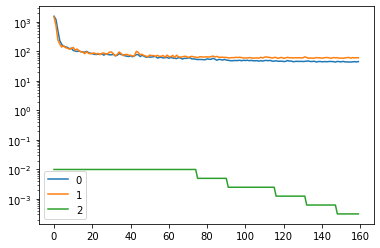

learning time: 0:01:31.445333


In [5]:
model_params = {'D_in': 23*23, 
                'H': 2048, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'ds_params': {'features': ['coulomb'],
                           'targets': ['E'],
                           'in_file': './data/qm7b/qm7b.mat',
                           'embed': []}}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 10,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=512, epochs=160)

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  6950
total molecular structures (idconf) mapped:  41537
epoch: 0 of 160, train loss: 34.66896695708774, val loss: 9.975679198979616, lr: 0.01
epoch: 16 of 160, train loss: 2.0288534528890914, val loss: 2.61411444781518, lr: 0.01
epoch: 32 of 160, train loss: 2.034846960417496, val loss: 1.6777843070898055, lr: 0.01
epoch: 48 of 160, train loss: 1.906424746995273, val loss: 1.8734533288170097, lr: 0.005
epoch: 64 of 160, train loss: 1.6735191252713957, val loss: 1.5689551098375318, lr: 0.005
epoch: 80 of 160, train loss: 1.6429636936622167, val loss: 1.513232842627764, lr: 0.0025
epoch: 96 of 160, t

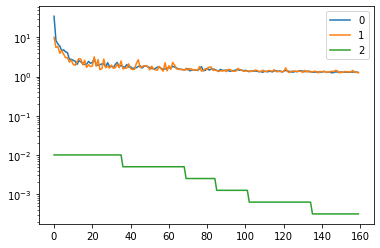

learning time: 0:05:19.611967


In [6]:
model_params = {'D_in': 23*23+23*64, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'ds_params': {'features': ['distance'],
                           'pad': 23,
                           'targets': ['eAT'],
                           'embed': [('atNUM',9,64,0,True)],
                           'selector': ['opt'],
                           'use_h5': False}}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 10,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=160)

#find the longest molecule
#qm7x = QM7X(**ds_params['ds_params'])
#l = 0
#for i in qm7x.ds_idx:
#    s = qm7x[i][0].shape.numel()
#    if s > l:
#        l = s
#print(l)

loading QM9 datadic from a pickled copy...
epoch: 0 of 100, train loss: 43.9585481825329, val loss: 18.661611080169678, lr: 0.01
epoch: 10 of 100, train loss: 1.8481530234927224, val loss: 1.9909127950668335, lr: 0.01
epoch: 20 of 100, train loss: 1.823080993833996, val loss: 1.8607863783836365, lr: 0.01
epoch: 30 of 100, train loss: 1.2803541989553542, val loss: 1.4273262321949005, lr: 0.005
epoch: 40 of 100, train loss: 1.0856123878842308, val loss: 1.2166612446308136, lr: 0.0025
epoch: 50 of 100, train loss: 1.0513449623471214, val loss: 1.18108931183815, lr: 0.0025
epoch: 60 of 100, train loss: 1.010106188910348, val loss: 1.132808655500412, lr: 0.0025
epoch: 70 of 100, train loss: 0.8853040280796233, val loss: 1.04524427652359, lr: 0.00125
epoch: 80 of 100, train loss: 0.8423069346518743, val loss: 0.9882014691829681, lr: 0.00125
epoch: 90 of 100, train loss: 0.7863211433092753, val loss: 0.9598112255334854, lr: 0.000625
test loss: 0.8953375101089478
y_pred:
tensor([[ 0.0677, -0.0

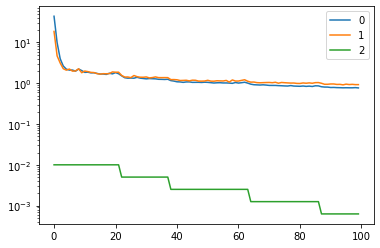

learning time: 0:01:27.667036


In [2]:
model_params = {'D_in': 12*12+12*12+12*12*16, 
                'H': 4096, 
                'D_out': 12, 
                'model_name': 'funnel'}

ds_params = {'ds_params': {'n': 133885, 
                           'features': ['distance','coulomb'],
                           'embed': [('adjacency',4,16,0,True)], 
                           'targets': ['mulliken'],
                           'pad': 12, 
                           'filter_on': ('n_atoms','<','13'),
                           'use_pickle': 'n_atoms_less_than_13.p'}}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=128, epochs=100)

creating QM9 dataset...
QM9 molecules scanned:  1
QM9 molecules created:  1
QM9 molecules scanned:  10001
QM9 molecules created:  10001
QM9 molecules scanned:  20001
QM9 molecules created:  20001
QM9 molecules scanned:  30001
QM9 molecules created:  30001
QM9 molecules scanned:  40001
QM9 molecules created:  40001
QM9 molecules scanned:  50001
QM9 molecules created:  50001
QM9 molecules scanned:  60001
QM9 molecules created:  60001
QM9 molecules scanned:  70001
QM9 molecules created:  70001
QM9 molecules scanned:  80001
QM9 molecules created:  80001
QM9 molecules scanned:  90001
QM9 molecules created:  90001
QM9 molecules scanned:  100001
QM9 molecules created:  100001
QM9 molecules scanned:  110001
QM9 molecules created:  110001
QM9 molecules scanned:  120001
QM9 molecules created:  120001
QM9 molecules scanned:  130001
QM9 molecules created:  130001
total QM9 molecules created: 130831
pickling a copy of the QM9 datadic...
epoch: 0 of 20, train loss: 18.489026544905027, val loss: 13.8

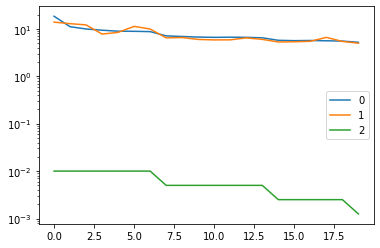

learning time: 0:56:51.050029


In [2]:
model_params = {'D_in': 29*29+29*29+29*29*8, 
                'H': 8192, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'ds_params': {'n': 133885, 
                           'features': ['distance','coulomb'],
                           'embed': [('adjacency',4,8,0,True)],
                           'targets': ['U0'],
                           'pad': 29, 
                           'filter_on': False,
                           'use_pickle': 'qm9.p'}}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}
opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=32, epochs=20)

structures loaded:  9342
epoch: 0 of 100, train loss: 323.4803761427234, val loss: 100.96379940446484, lr: 0.01
epoch: 10 of 100, train loss: 50.881917373528516, val loss: 43.46708709381892, lr: 0.01
epoch: 20 of 100, train loss: 36.771467066459515, val loss: 43.38448394527188, lr: 0.01
epoch: 30 of 100, train loss: 32.17626055596169, val loss: 29.126070602865823, lr: 0.01
epoch: 40 of 100, train loss: 25.7497624593712, val loss: 27.819199434193113, lr: 0.005
epoch: 50 of 100, train loss: 25.817560992561646, val loss: 27.895756386079693, lr: 0.005
epoch: 60 of 100, train loss: 24.99262253896126, val loss: 27.164169523244524, lr: 0.0025
epoch: 70 of 100, train loss: 22.54649879249085, val loss: 20.15377044254943, lr: 0.0025
epoch: 80 of 100, train loss: 24.234342063452544, val loss: 21.590327496387204, lr: 0.0025
epoch: 90 of 100, train loss: 21.046347970606277, val loss: 21.56666729553237, lr: 0.00125
test loss: 20.201593201326006
y_pred:
tensor([[-616.9171],
        [-327.6231],
     

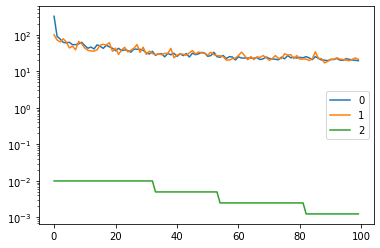

learning time: 0:03:05.984841


In [3]:
model_params = {'D_in': 64*63+63*63, 
                'H': 8192, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'ds_params': {'features': ['distance'],
                           'targets': ['wb97x_dz.energy'],
                           'embed': [('atomic_numbers',6,64,0,True)],
                           'pad': 63, #length of the longest molecule in the dataset
                           'criterion': 'wb97x_dz.energy',
                           'conformation': 'min',
                           'in_file': './data/ani1x/ani1x-release.h5'}}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 10,
                'cooldown': 10}
opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=128, epochs=100)